## SOLN - noise & mcmc

noise is part of working with data so let's learn how it works

we will cover
- what is noise
- nature of noise in data
- simulate noisy data
- what is mcmc
- mcmc on simulated data

### what is noise

noise in science is a very **__specific__** term (aka johnson nyquist noise) - you can't just say anything is noise. noise comes from the random motion of electrons and is directly proportional to temperature. noise originates in the electronics that are taking data - it does not exist in the source.

### noise in data

noise adds power to the data and is **gaussian**

### simulation - noise

imagine there is a source you are observing that emits energy in a gaussian distribution

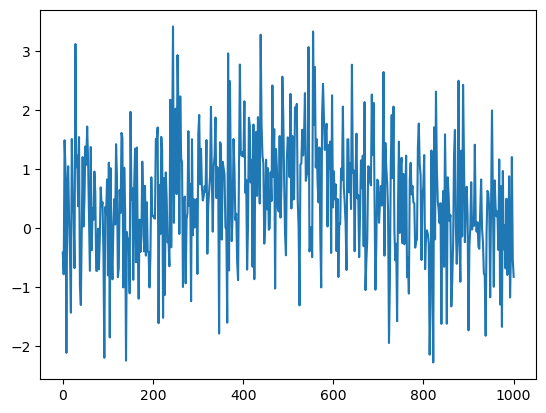

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define the functions we need
def gaussian(x, mu, std):
    '''
    evaluates the values of a gaussian distrubition given data

    parameters
    ----------
    x : array-like
        x data to evaluate a gaussian on
    mu : float
        mean of the gaussian
    std : float
        standard deviation of the gaussian

    returns
    ----------
    array-like : evaluated distribution with the same shape as x
    '''

    return np.exp(-0.5*(((x - mu)/std)**2))

# simulate a gaussian source
mu = 500    # mean
sigma = 200  # standard deviation
n = 500     # number of data points

x = np.linspace(0, 1000, n)
data = gaussian(x, mu, sigma)

# add noise to the data
noise = np.random.standard_normal(n) # noise from a standard normal distribution
data = data + noise

plt.plot(x, data)   # histogram to see the data
plt.show()


### what is mcmc

mcmc stands for markov chain monte carlo. please look into what markov chains are and what monte carlo means. this is just a way for you to see how this works. mcmc is a machine learning algorithm that allows you to fit paramters to a distribution. in other words, you can give it a function and some data and it will estimate the arguments into the function that would produce that data. it chooses the parameters that minimize the least-squares difference between the distribution and the data (aka minimizing the loss).

how does it do this? imagine a hilly terrain where walking in one dimension is changing one parameter (say, x) and the other direction is another parameter (say, y). we want to figure out which combination of x and y represents our data. we want to find f(x, y) that produced the data. this hilly terrain is known as the parameter space and the correct combination of x and y is on top of the highest hill. what does the f(x, y) represent? it is the loss function but negated so that the minimum loss is at the top of hte highest hill.

we want to start somewhere random and make tiny random changes to x and y to see which changes are effective in decreasing the loss with respect to where we are currently standing. this keeps going until we reach the top of the highest hill. we know we are there because any change we make would cause the f(x, y) of the new spot to be less than the one we currenly stand on.

the implementation we will use does something clever here. it will randomly take that step downhill. why? in case we are stuck on a local maxima - a hill that isn't the tallest hill. it also has a No U-Turns (NUTS) sampler that does not retrace steps to save time and energy.

this was a LOT of ML jargon but it's helpful to know how your algorithms work. this is a very surface level view of mcmc so please read more online if you're interested, it's super cool.

### simulation - mcmc

let's put the simulated data through mcmc to see if we can pull the original gaussian parameters back out!
again lots of ML jargon so please ask questions and look up more information!

In [2]:
# mcmc implementation
import pymc as pm
import arviz as az


In [3]:
# define the mcmc trial
def mcmc_trial(x, data):
    # start a 'model context' - this defines a space for all the vars and likelihoods for this model
    with pm.Model() as model:
        # define a 'prior distribution' for the mean (can start anywhere btwn 0 and 1000 w equal probability)
        mu = pm.Uniform('mu', lower=0, upper=1000)  

        # define a prior over the standard deviation (lognormal since stdvs are always > 0)
        sigma = pm.LogNormal('sigma', mu=np.log(100), sigma=1)

        # feed the gaussian into the model
        model_prediction = gaussian(x, mu, sigma)

        # likelihood function - gives the model a way to work with predictions vs observations
        pm.Normal("obs", mu=model_prediction, sigma=1.0, observed=data)

        # sample from posterior distribution
        trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=True)
        return trace
    

In [4]:
# run mcmc

run = mcmc_trial(x, data)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# see the mcmc results as a pandas dataframe
az.summary(run)


pandas.core.frame.DataFrame

In [ ]:
# compare to actual values
mu,sigma


(500, 200)